# 다음에 볼 영화 예측하기
Movielens 1M Dataset 데이터 기반으로, Session based Recommendation 시스템을 제작하겠습니다. 



In [1]:
import datetime as dt
import os
from pathlib import Path

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## 1. 데이터 파악
- Time 항목에는 UTC time가 포함
- 1970년 1월 1일부터 경과된 초단위 시간입니다.

### 1.1 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/ml-1m')
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ml-1m/ratings.dat')

In [3]:
data_cols = ['UserId', 'ItemId', 'rating', 'timestamp']
data = pd.read_csv(train_path, sep='::', names=data_cols, engine='python', encoding = "ISO-8859-1")
data

,UserId,ItemId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### 1.2 timestamp 컬럼 수정

In [4]:
data = data.sort_values(by=['UserId','timestamp'], ascending=[True,True])
data = data.reset_index(drop=True)
data

,UserId,ItemId,rating,timestamp
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103
...,...,...,...,...
1000204,6040,2917,4,997454429
1000205,6040,1921,4,997454464
1000206,6040,1784,3,997454464
1000207,6040,161,3,997454486


In [5]:
import datetime

data['Time'] = data['timestamp'].apply(lambda x : datetime.datetime.fromtimestamp(x))
data

,UserId,ItemId,rating,timestamp,Time
0,1,3186,4,978300019,2000-12-31 22:00:19
1,1,1270,5,978300055,2000-12-31 22:00:55
2,1,1721,4,978300055,2000-12-31 22:00:55
3,1,1022,5,978300055,2000-12-31 22:00:55
4,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000204,6040,2917,4,997454429,2001-08-10 14:40:29
1000205,6040,1921,4,997454464,2001-08-10 14:41:04
1000206,6040,1784,3,997454464,2001-08-10 14:41:04
1000207,6040,161,3,997454486,2001-08-10 14:41:26


## 2. 데이터 전처리
- 항목별 기본분석, user length, timestamp, cleaning 등의 작업을 진행
- UserID를 어떻게 Session 단위로 해석할지 고민


### 2.1 UserId To SessionId

In [6]:
data_ = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
data_

,UserId,Time,ItemId
0,1,2000-12-31 22:00:19,1
1,1,2000-12-31 22:00:55,3
2,1,2000-12-31 22:01:43,1
3,1,2000-12-31 22:02:52,1
4,1,2000-12-31 22:04:35,1
...,...,...,...
471158,6040,2001-08-10 14:39:58,1
471159,6040,2001-08-10 14:40:29,1
471160,6040,2001-08-10 14:41:04,2
471161,6040,2001-08-10 14:41:26,1


In [7]:
# Index를 SessionId로 쓰기 위해 컬럼 생성
data_.reset_index(inplace=True)
data_

,index,UserId,Time,ItemId
0,0,1,2000-12-31 22:00:19,1
1,1,1,2000-12-31 22:00:55,3
2,2,1,2000-12-31 22:01:43,1
3,3,1,2000-12-31 22:02:52,1
4,4,1,2000-12-31 22:04:35,1
...,...,...,...,...
471158,471158,6040,2001-08-10 14:39:58,1
471159,471159,6040,2001-08-10 14:40:29,1
471160,471160,6040,2001-08-10 14:41:04,2
471161,471161,6040,2001-08-10 14:41:26,1


In [8]:
df = pd.merge(data, data_, how='inner', on=['UserId', 'Time'])
df

,UserId,ItemId_x,rating,timestamp,Time,index,ItemId_y
0,1,3186,4,978300019,2000-12-31 22:00:19,0,1
1,1,1270,5,978300055,2000-12-31 22:00:55,1,3
2,1,1721,4,978300055,2000-12-31 22:00:55,1,3
3,1,1022,5,978300055,2000-12-31 22:00:55,1,3
4,1,2340,3,978300103,2000-12-31 22:01:43,2,1
...,...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,2001-08-10 14:40:29,471159,1
1000205,6040,1921,4,997454464,2001-08-10 14:41:04,471160,2
1000206,6040,1784,3,997454464,2001-08-10 14:41:04,471160,2
1000207,6040,161,3,997454486,2001-08-10 14:41:26,471161,1


In [9]:
data = df[['UserId', 'ItemId_x', 'rating', 'Time', 'index']]
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


### 2.2 이상치 확인 및 처리
먼저, SessionID 확인

In [10]:
# SessionID를 공유하는 데이터 row의 개수
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [11]:
# 세션 길이 중간값, 평균
print(session_length.median(), session_length.mean())

# 세션 길이 최소값, 최대값
print(session_length.min(), session_length.max())

# 99.9% 세션은 길이
print(session_length.quantile(0.999))

2.0 2.1228513274599234
1 30
10.0


In [12]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

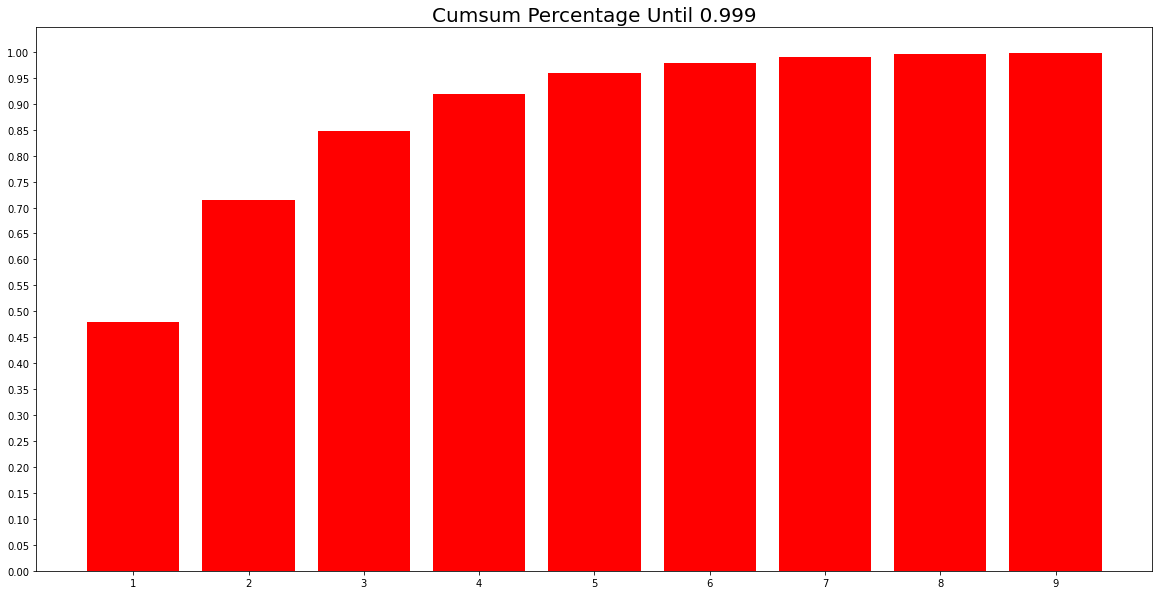

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

- SessionId 사이즈 2이하는 처리해야겠음

아이템ID도 확인

In [14]:
# ItemId를 공유하는 데이터 row의 개수
Item_length = data.groupby('ItemId').size()
Item_length

# 중간값, 평균
print(Item_length.median(), Item_length.mean())

# 최소값, 최대값
print(Item_length.min(), Item_length.max())

# 90%
print(Item_length.quantile(0.9))

123.5 269.88909875876953
1 3428
729.5


In [15]:
# 90%
length_count = Item_length.groupby(Item_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_90 = length_percent_cumsum[length_percent_cumsum < 0.9]

length_percent_cumsum_90

1      0.030761
2      0.054776
3      0.066109
4      0.078251
5      0.088775
         ...   
720    0.898273
722    0.898813
723    0.899083
724    0.899352
729    0.899892
Length: 627, dtype: float64

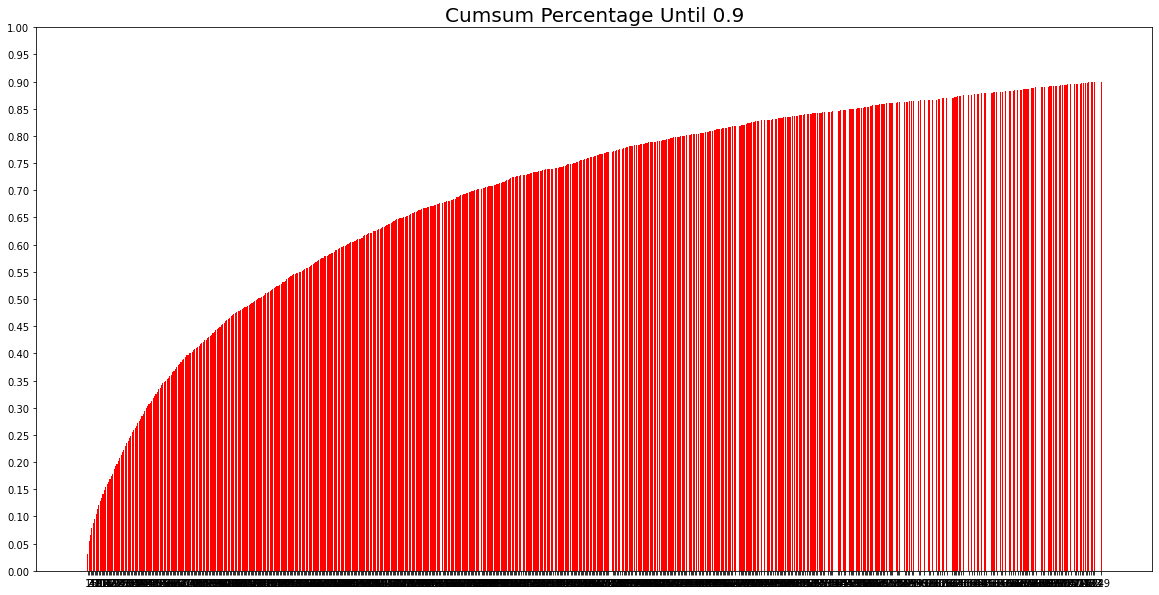

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_90.index,
        height=length_percent_cumsum_90, color='red')
plt.xticks(length_percent_cumsum_90.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.9', size=20)
plt.show()

- 음... 너무 많다

In [17]:
counts = data['Time'].value_counts()

counts.describe()

count    458455.000000
mean          2.181695
std           1.629193
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
Name: Time, dtype: float64

3 이상인 값은 이상값으로 처리해야겠당

In [18]:
data = data[data['Time'].isin(counts[counts < 4].index)]

data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


In [19]:
# 유저 수, 아이템 수
data['SessionId'].nunique(), data['ItemId'].nunique()

(388016, 3617)

In [20]:
# 데이터의 기간 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [21]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

### 2.3 데이터 전처리

In [22]:
# 전처리 함수
def cleanse_recursive(data: pd.DataFrame, shortest, least_watch, least_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_movie(data, least_watch)
        data = cleanse_low_rating(data, least_rating)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

# 최소 세션 개수
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

# 인기없는 영화 제거
def cleanse_unpopular_movie(data: pd.DataFrame, least_watch):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_watch].index
    data = data[data['ItemId'].isin(item_use)]
    return data

# 낮은 평점 제거
def cleanse_low_rating(data: pd.DataFrame, least_rating):
    data = data[data['Rating']>=3]
    return data

data = cleanse_recursive(data, shortest=1, least_watch=50, least_rating=3)
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


## 3. 미니 배치 구성
- 데이터셋과 미니 배치 구성
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
- Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [23]:
# 데이터셋 나누는 함수
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [24]:
# test, val 기간을 30일로 설정
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [25]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [26]:
# 나뉘어진 데이터셋 확인
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 482797
	 Sessions: 325300
	 Items: 1885
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 16:54:04

* valid Set Stats Info
	 Events: 1134
	 Sessions: 923
	 Items: 741
	 First Time : 2002-12-30 18:21:02
	 Last Time : 2003-01-29 17:00:13

* test Set Stats Info
	 Events: 1013
	 Sessions: 810
	 Items: 695
	 First Time : 2003-01-29 19:37:31
	 Last Time : 2003-02-28 17:49:50



In [27]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [28]:
#데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 4. 모델 구성
- 다양한 모델 구조 시도

In [29]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [30]:
# train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [31]:
# click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
tr_dataset.click_offsets

array([     0,      1,      4, ..., 482795, 482796, 482797], dtype=int32)

In [32]:
# session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.
tr_dataset.session_idx

array([     0,      1,      2, ..., 325297, 325298, 325299])

In [33]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    # 모델 인푸스 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        # mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.
        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [34]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [35]:
iter_ex = iter(tr_data_loader)

In [36]:
# 이 셀을 반복하면 next가 계속 다음 데이터를 만듭니다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


In [37]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [39]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [40]:
# 모델에 사용할 hyper-parameter를 class 형식으로 관리하겠습니다.
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [41]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 1885)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      290550    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 1885)                96135     
Total params: 386,685
Trainable params: 386,685
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증
- Recall, MRR 등의 개념들고 함께 관리

In [42]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [43]:
# 모델 학습
train_model(model, args)

Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0, train_loss=6.96]     

	 - Recall@20 epoch 1: 0.135417
	 - MRR@20    epoch 1: 0.058565



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0, train_loss=6.65]     

	 - Recall@20 epoch 2: 0.197917
	 - MRR@20    epoch 2: 0.088106



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.42]

	 - Recall@20 epoch 3: 0.208333
	 - MRR@20    epoch 3: 0.111813



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.32]

	 - Recall@20 epoch 4: 0.244792
	 - MRR@20    epoch 4: 0.113790



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.2] 

	 - Recall@20 epoch 5: 0.244792
	 - MRR@20    epoch 5: 0.111195



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.14]

	 - Recall@20 epoch 6: 0.255208
	 - MRR@20    epoch 6: 0.113754



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.07]

	 - Recall@20 epoch 7: 0.250000
	 - MRR@20    epoch 7: 0.121723



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.05]

	 - Recall@20 epoch 8: 0.265625
	 - MRR@20    epoch 8: 0.123514



Train:   0%|          | 0/2460 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.95]

	 - Recall@20 epoch 9: 0.286458
	 - MRR@20    epoch 9: 0.124426



Evaluation: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

	 - Recall@20 epoch 10: 0.291667
	 - MRR@20    epoch 10: 0.118484



## 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR을 확인

In [44]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

	 - Recall@20: 0.270833
	 - MRR@20: 0.104261



## 6. 회고
데이터 전처리 과정에서 SessionId를 다르게 처리해보기도 하고,  
하이퍼파라미터에서 hsz, k 값 등을 바꿔보면서 학습해봤지만 유의미한 차이는 없었다.  

그리고 epoch을 늘려봤지만 오히려 오버피팅 현상이 보였다.  



그나저나 이번건 진짜 너무 어려웠다  
간만에 멘탈나간듯...